<a href="https://colab.research.google.com/github/wildlyclassyprince/data-playground/blob/master/nlp-with-tensorflow/notebooks/nlp-with-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP) with TensorFlow

Inspired by work from the Standford University course CS224N, we will explore some of the currently common techniques associated with Natural Language Processing and Deep Learning.

In this notebook we will classify Twitter data and build a model that predicts the owner of a tweet.

## Table of Contents
* **[Getting the data](#getting-the-data)**
* **[Preprocessing](#preprocessing)**
  * [Concatenate dataframes](#concatenate)
  * [Format the text](#format-text)
* **[Training and validation data](#training-validation-data)**
  * [Create feature set](#feature-set)
  * [Create label set](#label-set)
  * [Create train and test sets](#train-test-split)
  * [Create validation set](#validation-set)
* **[Build the model](#build-model)**
  * [Loss function and optimizer](#loss-function-and-optimizer)
* **[Train the model](#train-model)**
* **[Evaluate the model](#evaluate-model)**
  * [Plot accuracy and loss over time](#plot-accuracy-and-loss)

In [0]:
# Header
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [0]:
# The usual suspects ...
import io
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from numpy import array
from numpy import argmax
from nltk.tokenize import wordpunct_tokenize
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

<a id='getting-the-data'></a>
### Gettting the data

In [6]:
# Upload files
uploaded = files.upload()

Saving senators.csv to senators.csv
Saving realDonaldTrump.csv to realDonaldTrump.csv
Saving BarackObama.csv to BarackObama.csv


In [0]:
# Trump
trump = pd.read_csv(io.BytesIO(uploaded['realDonaldTrump.csv']), lineterminator='\n')
# Obama
obama = pd.read_csv(io.BytesIO(uploaded['BarackObama.csv']), lineterminator='\n')
# Senators
senators = pd.read_csv(io.BytesIO(uploaded['senators.csv']), lineterminator='\n')

<a id='preprocessing'></a>
### Preprocessing


<a id='concatenate'></a>
#### Concatenate dataframes

In [0]:
df = pd.concat([trump, obama, senators])

<a id='format-text'></a>
#### Format the text

In [0]:
# Text corpus
def create_document_corpus(df, column):
    '''Creates document corpus.'''
    return [i for i in df[column]]

# Removing common words and tokenize
def tokenize(document_corpus):
    '''Tokenizes text.'''
    return [[word for word in doc.lower().split()] for doc in document_corpus]

# Formatting
document = create_document_corpus(df, 'text')
tokenised_doc = tokenize(document)
dictionary = corpora.Dictionary(tokenised_doc)

In [13]:
print(dictionary)

Dictionary(458047 unique tokens: ['a', 'and', 'beginning,', 'conversation', 'david']...)


<a id='training-validation-data'></a>
### Training & validation data

<a id='feature-set'></a>
#### Creating feature set

In [0]:
# Feature
data = list(map(lambda item: dictionary.doc2idx(tokenised_doc[item]),
                range(len(tokenised_doc))))

<a id='label-set'></a>
#### Creating label set

In [15]:
# Labels
def encode(dataset):
    print(f'Shape before encoding: {len(dataset)}')
    encoded = tf.keras.utils.to_categorical(dataset)
    print(f'Shape after encoding: {encoded.shape}')
    return encoded

values = array(df['user'].values)
label_encoder = LabelEncoder()
integer_encodings = label_encoder.fit_transform(values)
labels = encode(integer_encodings)

Shape before encoding: 295054
Shape after encoding: (295054, 102)


<a id='train-test-split'></a>
#### Create training  and test set

In [16]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.25, shuffle=True)
print(f'X-train: {len(x_train)}, Y-train: {len(y_train)}')
print(f'X-test: {len(x_test)}, Y-test: {len(y_test)}')

X-train: 221290, Y-train: 221290
X-test: 73764, Y-test: 73764


In [0]:
# Pad the data
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=45)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=45)

<a id='validation-set'></a>
#### Create validation set

In [0]:
# Feature set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

# Label set 
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

<a id='build-model'></a>
### Build the model

The model we will build will take input data consisting of an array of word-indices, while the labels to predict are the names of senators.

In [19]:
vocab_size = 458047

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(102, activation=tf.nn.softmax))
model.summary()

W0813 11:14:12.236478 139707649181568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 11:14:12.295757 139707649181568 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         58630016  
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 102)               13158     
Total params: 58,659,686
Trainable params: 58,659,686
Non-trainable params: 0
_________________________________________________________________


<a id='loss-function-and-optimizer'></a>
#### Loss function and optimizer

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

<a id='train-model'></a>
### Train the model

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 211290 samples, validate on 10000 samples
Epoch 1/10
211290/211290 [==============================] - 273s 1ms/sample - loss: 4.4882 - acc: 0.0390 - val_loss: 4.1762 - val_acc: 0.0952
Epoch 2/10
211290/211290 [==============================] - 267s 1ms/sample - loss: 3.6793 - acc: 0.1853 - val_loss: 3.3769 - val_acc: 0.2546
Epoch 3/10
211290/211290 [==============================] - 267s 1ms/sample - loss: 2.7613 - acc: 0.3919 - val_loss: 2.8854 - val_acc: 0.3735
Epoch 4/10
211290/211290 [==============================] - 271s 1ms/sample - loss: 2.0193 - acc: 0.5666 - val_loss: 2.6335 - val_acc: 0.4295
Epoch 5/10
211290/211290 [==============================] - 271s 1ms/sample - loss: 1.4539 - acc: 0.7002 - val_loss: 2.5381 - val_acc: 0.4567
Epoch 6/10
211290/211290 [==============================] - 271s 1ms/sample - loss: 1.0365 - acc: 0.7940 - val_loss: 2.5384 - val_acc: 0.4654
Epoch 7/10
211290/211290 [==============================] - 267s 1ms/sample - loss: 0.7376 - acc:

<a id='evaluate-model'></a>
### Evaluate the model

In [22]:
results = model.evaluate(x_test, y_test)
print(results)

73764/73764 [==============================] - 3s 44us/sample - loss: 2.7939 - acc: 0.4767
[2.7939490478795506, 0.47669595]


<a id='plot-accuracy-and-loss'></a>
#### Plot accuracy and loss over time

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

Text(0.5, 0, 'Epochs')

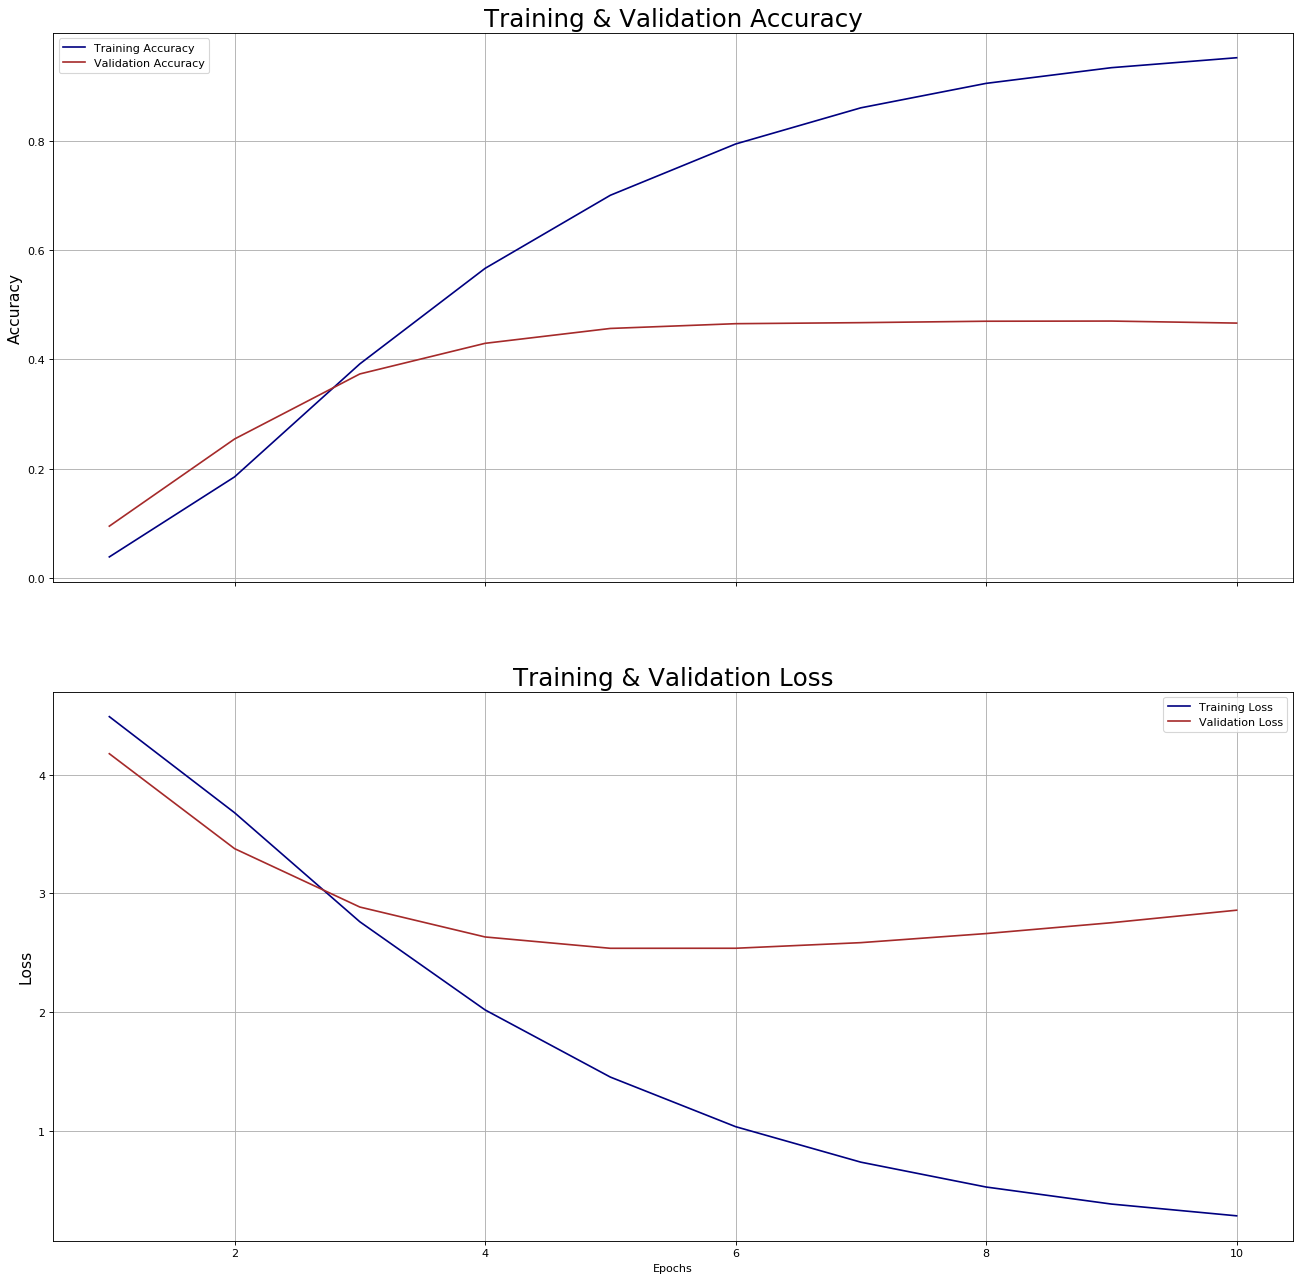

In [25]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=80, sharex=True)
sns.lineplot(epochs, acc, label='Training Accuracy', color='navy', ax=ax1)
sns.lineplot(epochs, val_acc, label='Validation Accuracy', color='brown', ax=ax1)
sns.lineplot(epochs, loss, label='Training Loss', color='navy', ax=ax2)
sns.lineplot(epochs, val_loss, label='Validation Loss', color='brown', ax=ax2)
ax1.set_title('Training & Validation Accuracy', fontsize=22)
ax2.set_title('Training & Validation Loss', fontsize=22)
ax1.set_ylabel('Accuracy', fontsize=14)
ax2.set_ylabel('Loss', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()
plt.xlabel('Epochs')